# Testing max_layers Functionality with 20 Newsgroups Dataset

This notebook demonstrates the `max_layers` parameter using the 20 newsgroups dataset with pre-computed embeddings.

In [ ]:
# Install required packages if needed
!pip install pandas pyarrow

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toponymy.clustering import (
    build_raw_cluster_layers,
    ToponymyClusterer
)
from toponymy.cluster_layer import ClusterLayerText
import time

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/keyu/miniconda3/envs/toponymy-test/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/keyu/miniconda3/envs/toponymy-test/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/keyu/miniconda3/envs/toponymy-test/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance(

## Step 1: Load 20 Newsgroups Dataset with Embeddings

In [2]:
# Load the 20newsgroups dataset from Hugging Face
print("Loading 20 newsgroups dataset...")
newsgroups_df = pd.read_parquet("hf://datasets/lmcinnes/20newsgroups_embedded/data/train-00000-of-00001.parquet")

# Extract text, embeddings, and 2D map
text = newsgroups_df["post"].str.strip().values
document_vectors = np.stack(newsgroups_df["embedding"].values)  # 768-dim embeddings
document_map = np.stack(newsgroups_df["map"].values)  # 2D UMAP coordinates

print(f"Loaded {len(text)} documents")
print(f"Document vectors shape: {document_vectors.shape}")
print(f"Document map shape: {document_map.shape}")
print(f"\nExample document:")
print(f"Text: {text[0][:200]}...")

Loading 20 newsgroups dataset...
Loaded 18170 documents
Document vectors shape: (18170, 768)
Document map shape: (18170, 2)

Example document:
Text: I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I...


## Step 2: Visualize Document Distribution

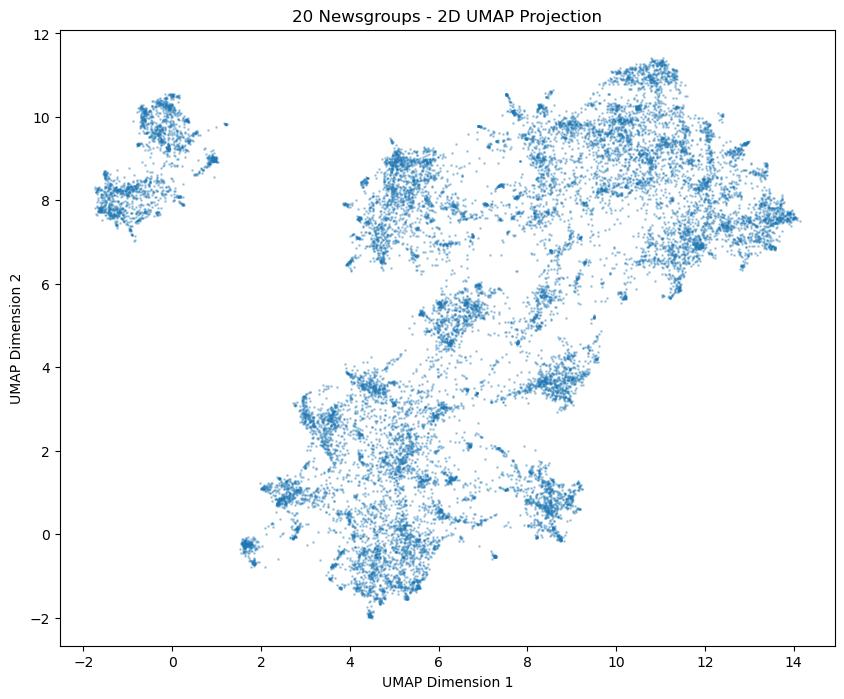

In [3]:
# Plot the 2D distribution of documents
plt.figure(figsize=(10, 8))
plt.scatter(document_map[:, 0], document_map[:, 1], alpha=0.3, s=1)
plt.title("20 Newsgroups - 2D UMAP Projection")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

## Step 3: Test max_layers with build_raw_cluster_layers

In [4]:
# Test with no limit (max_layers=None)
print("Testing with no layer limit (max_layers=None)...")
layers_unlimited = build_raw_cluster_layers(
    document_map,
    min_clusters=3,
    min_samples=5,
    base_min_cluster_size=50,
    max_layers=None,
    verbose=True
)
print(f"\nCreated {len(layers_unlimited)} layers without limit")

Testing with no layer limit (max_layers=None)...
Layer 0 found 95 clusters
Layer 1 found 32 clusters
Layer 2 found 14 clusters
Layer 3 found 6 clusters
Layer 4 found 3 clusters

Created 5 layers without limit


In [13]:
# Test with max_layers=3
print("\nTesting with max_layers=3...")
layers_limited_3 = build_raw_cluster_layers(
    document_map,
    min_clusters=3,
    min_samples=5,
    base_min_cluster_size=50,
    max_layers=3,
    verbose=True
)
print(f"\nCreated {len(layers_limited_3)} layers with max_layers=3")
assert len(layers_limited_3) <= 3, "Should create at most 3 layers"


Testing with max_layers=3...
Layer 0 found 95 clusters
Layer 1 found 32 clusters
Layer 2 found 14 clusters

Created 3 layers with max_layers=3


## Step 4: Test ToponymyClusterer with max_layers

In [6]:
# Create clusterers with different max_layers settings
clusterer_no_limit = ToponymyClusterer(
    min_clusters=3,
    min_samples=5,
    base_min_cluster_size=50,
    max_layers=None,  # No limit
    verbose=False
)

clusterer_limit_3 = ToponymyClusterer(
    min_clusters=3,
    min_samples=5,
    base_min_cluster_size=50,
    max_layers=3,  # Limited to 3 layers
    verbose=False
)

# Fit both clusterers
print("Fitting clusterer with no limit...")
layers_no_limit, tree_no_limit = clusterer_no_limit.fit_predict(
    clusterable_vectors=document_map,
    embedding_vectors=document_vectors,
    layer_class=ClusterLayerText,
    show_progress_bar=False
)

print("Fitting clusterer with max_layers=3...")
layers_limit_3, tree_limit_3 = clusterer_limit_3.fit_predict(
    clusterable_vectors=document_map,
    embedding_vectors=document_vectors,
    layer_class=ClusterLayerText,
    show_progress_bar=False
)

print(f"\nNo limit: {len(layers_no_limit)} layers")
print(f"max_layers=3: {len(layers_limit_3)} layers")

Fitting clusterer with no limit...
Fitting clusterer with max_layers=3...

No limit: 4 layers
max_layers=3: 3 layers


## Step 5: Analyze Cluster Distribution

In [7]:
# Function to analyze cluster distribution
def analyze_layers(layers, title):
    print(f"\n{title}:")
    print("-" * 50)
    
    data = []
    for i, layer in enumerate(layers):
        n_clusters = len(np.unique(layer.cluster_labels[layer.cluster_labels >= 0]))
        n_noise = np.sum(layer.cluster_labels == -1)
        
        data.append({
            'Layer': i,
            'Number of Clusters': n_clusters,
            'Noise Points': n_noise,
            'Total Points': len(layer.cluster_labels)
        })
        
    df = pd.DataFrame(data)
    print(df.to_string(index=False))
    return df

# Analyze both clustering results
df_no_limit = analyze_layers(layers_no_limit, "Clustering with No Limit")
df_limit_3 = analyze_layers(layers_limit_3, "Clustering with max_layers=3")


Clustering with No Limit:
--------------------------------------------------
 Layer  Number of Clusters  Noise Points  Total Points
     0                  95          7660         18170
     1                  27          6331         18170
     2                  10          4164         18170
     3                   3          6942         18170

Clustering with max_layers=3:
--------------------------------------------------
 Layer  Number of Clusters  Noise Points  Total Points
     0                  95          7660         18170
     1                  27          6331         18170
     2                  10          4164         18170


## Step 6: Visualize Hierarchy

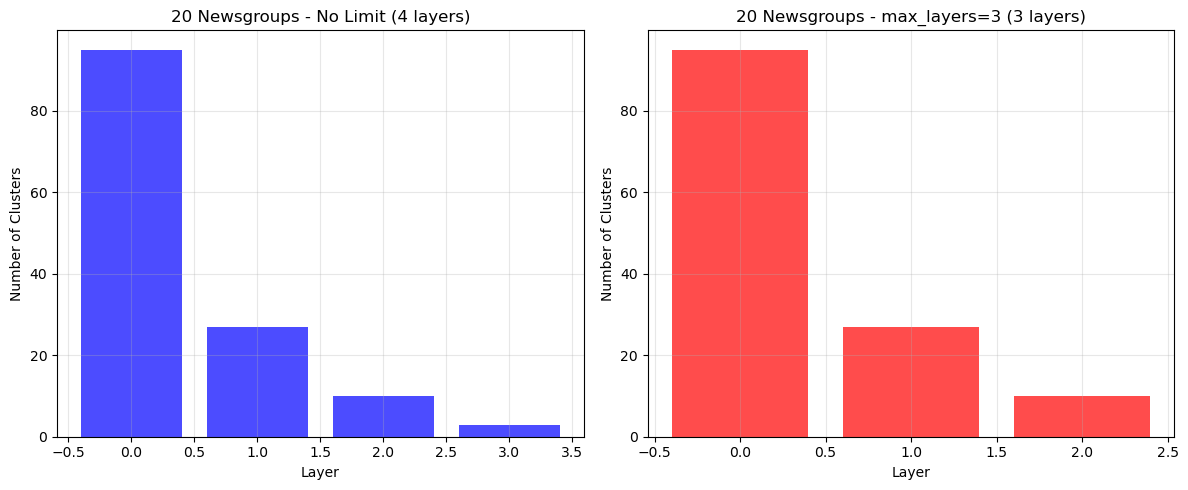

In [8]:
# Visualize the number of clusters at each layer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for unlimited layers
ax1.bar(df_no_limit['Layer'], df_no_limit['Number of Clusters'], color='blue', alpha=0.7)
ax1.set_xlabel('Layer')
ax1.set_ylabel('Number of Clusters')
ax1.set_title(f'20 Newsgroups - No Limit ({len(layers_no_limit)} layers)')
ax1.grid(True, alpha=0.3)

# Plot for limited layers
ax2.bar(df_limit_3['Layer'], df_limit_3['Number of Clusters'], color='red', alpha=0.7)
ax2.set_xlabel('Layer')
ax2.set_ylabel('Number of Clusters')
ax2.set_title(f'20 Newsgroups - max_layers=3 ({len(layers_limit_3)} layers)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Visualize Clusters on 2D Map

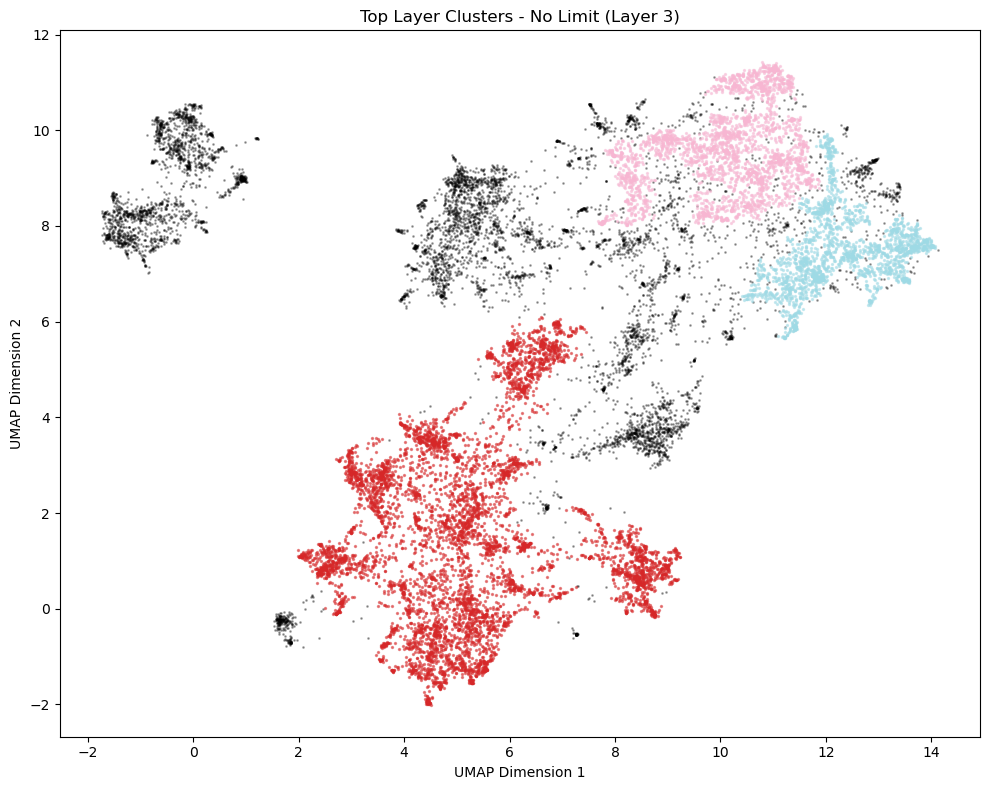

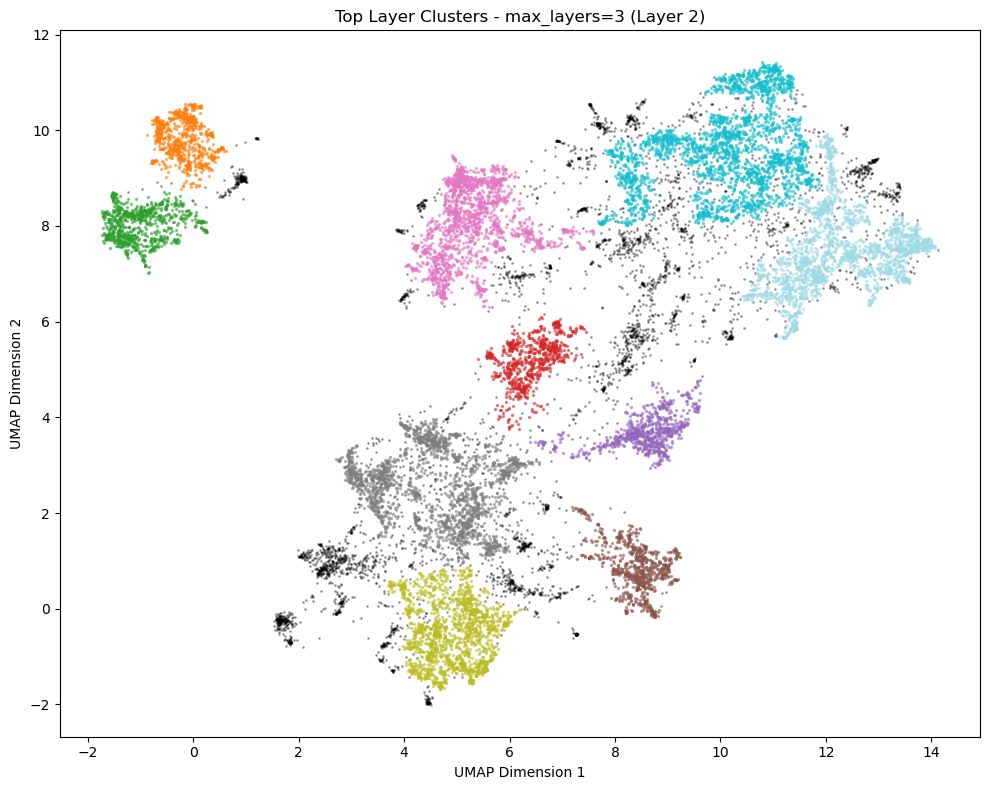

In [9]:
# Function to plot clusters
def plot_clusters(coords, labels, title):
    plt.figure(figsize=(10, 8))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, min(20, len(unique_labels))))
    
    for i, label in enumerate(unique_labels):
        if label == -1:
            # Noise points in black
            mask = labels == label
            plt.scatter(coords[mask, 0], coords[mask, 1], 
                       c='black', s=1, alpha=0.3, label='Noise')
        else:
            mask = labels == label
            color_idx = i % len(colors)
            plt.scatter(coords[mask, 0], coords[mask, 1], 
                       c=[colors[color_idx]], s=2, alpha=0.5)
    
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.tight_layout()
    plt.show()

# Plot top layer clusters for both approaches
if len(layers_no_limit) > 0:
    plot_clusters(document_map, layers_no_limit[-1].cluster_labels, 
                  f"Top Layer Clusters - No Limit (Layer {len(layers_no_limit)-1})")

if len(layers_limit_3) > 0:
    plot_clusters(document_map, layers_limit_3[-1].cluster_labels, 
                  f"Top Layer Clusters - max_layers=3 (Layer {len(layers_limit_3)-1})")

## Step 8: Performance Comparison

max_layers=1: 1 layers created in 0.053 seconds
max_layers=2: 2 layers created in 0.067 seconds
max_layers=3: 3 layers created in 0.084 seconds
max_layers=4: 4 layers created in 0.099 seconds
max_layers=5: 4 layers created in 0.106 seconds
max_layers=None: 4 layers created in 0.099 seconds


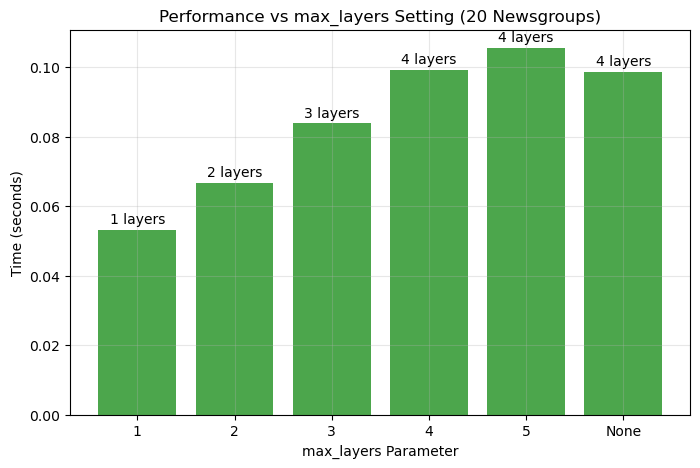

In [10]:
# Compare performance with different max_layers values
max_layers_values = [1, 2, 3, 4, 5, None]
times = []
n_layers_created = []

for max_layers in max_layers_values:
    clusterer = ToponymyClusterer(
        min_clusters=3,
        min_samples=5,
        base_min_cluster_size=50,
        max_layers=max_layers,
        verbose=False
    )
    
    start_time = time.time()
    layers, _ = clusterer.fit_predict(
        clusterable_vectors=document_map,
        embedding_vectors=document_vectors,
        layer_class=ClusterLayerText,
        show_progress_bar=False
    )
    end_time = time.time()
    
    times.append(end_time - start_time)
    n_layers_created.append(len(layers))
    
    print(f"max_layers={max_layers}: {len(layers)} layers created in {end_time - start_time:.3f} seconds")

# Plot performance
fig, ax = plt.subplots(figsize=(8, 5))
x_labels = [str(v) if v is not None else 'None' for v in max_layers_values]
bars = ax.bar(x_labels, times, color='green', alpha=0.7)

# Add layer count labels on bars
for bar, n_layers in zip(bars, n_layers_created):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{n_layers} layers', ha='center', va='bottom')

ax.set_xlabel('max_layers Parameter')
ax.set_ylabel('Time (seconds)')
ax.set_title('Performance vs max_layers Setting (20 Newsgroups)')
ax.grid(True, alpha=0.3)
plt.show()

## Step 9: Show Sample Documents from Clusters

In [11]:
# Show sample documents from different clusters in the finest layer
layer_0_labels = layers_no_limit[0].cluster_labels
unique_clusters = np.unique(layer_0_labels[layer_0_labels >= 0])[:5]  # First 5 clusters

for cluster_id in unique_clusters:
    print(f"\n{'='*80}")
    print(f"Cluster {cluster_id}:")
    print('='*80)
    
    # Get documents in this cluster
    cluster_mask = layer_0_labels == cluster_id
    cluster_indices = np.where(cluster_mask)[0][:3]  # First 3 documents
    
    for idx in cluster_indices:
        print(f"\nDocument {idx}:")
        print(f"Text: {text[idx][:300]}...")
        print("-" * 40)


Cluster 0:

Document 7:
Text: [stuff deleted]

Ok, here's the solution to your problem.  Move to Canada.  Yesterday I was able
to watch FOUR games...the NJ-PITT at 1:00 on ABC, LA-CAL at 3:00 (CBC), 
BUFF-BOS at 7:00 (TSN and FOX), and MON-QUE at 7:30 (CBC).  I think that if
each series goes its max I could be watching hockey pl...
----------------------------------------

Document 79:
Text: Well I think whenever ESPN covers the game they do a wonderful job. But
   what I don't understand is that they cut the OT just show some stupid
   baseball news which is not important at all. Then I waited for the scores
   to comeon Sportscenter, but they talk about Baseball, basketball and 
   fo...
----------------------------------------

Document 103:
Text: I haven't heard any news about ASN carrying any games but the local
cable station here in St. John's (Cable 9) is carrying the games live!

Hey, it's better than nothing!

GO LEAFS GO!!!

Dale...
----------------------------------------



## Summary

This notebook demonstrates the `max_layers` functionality using the 20 newsgroups dataset:

1. **The `max_layers` parameter successfully limits hierarchy depth** - preventing creation of more layers than specified

2. **Performance benefits** - Limiting layers reduces computation time, especially important for large datasets

3. **Flexibility** - Users can control the granularity of their topic hierarchy based on their needs

### Usage Example:

```python
from toponymy import Toponymy, ToponymyClusterer
from sentence_transformers import SentenceTransformer

# Create a clusterer with limited hierarchy
clusterer = ToponymyClusterer(
    min_clusters=3,
    base_min_cluster_size=50,
    max_layers=3  # Limit to 3 hierarchy levels
)

# Use it in Toponymy
toponymy = Toponymy(
    llm_wrapper=your_llm,
    text_embedding_model=SentenceTransformer('all-MiniLM-L6-v2'),
    clusterer=clusterer,
    object_description="newsgroup posts",
    corpus_description="collection of newsgroup discussions"
)

# Fit on the documents
toponymy.fit(
    objects=text,
    embedding_vectors=document_vectors,
    clusterable_vectors=document_map
)
```